In [61]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [41]:
# --- Load Data ---
data = pd.read_csv('sept2013c3.csv')
X = data.drop(columns=['Class'])
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Function for evaluating models
def optimal_threshold (y_pred):
    precision, recall, optthreshold = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    opt_threshold = optthreshold[optimal_idx]
    print(f"Optimal Threshold: {opt_threshold:.2f}")
    
def evalThresholds (y_pred_proba, thresholds):
    for threshold in thresholds:
            y_pred_adjusted = (y_pred_proba > threshold).astype(int)
            print(f"\n-------- Threshold: {threshold} --------")
            print("Confusion Matrix:")
            print(confusion_matrix(y_test, y_pred_adjusted))
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_adjusted, target_names=['Class 0', 'Class 1']))
            print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


def evaluate_model(model, X_test, y_test, thresholds=[.5]):
    if isinstance(model, LogisticRegression):
        y_pred = model.predict_proba(X_test)[:, 1]
        optimal_threshold(y_pred)
        
    if hasattr(model, 'predict_proba'):
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.predict(X_test)
        optimal_threshold(y_pred)

    evalThresholds(y_pred, thresholds)

In [4]:
# --- Train Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [45]:
evaluate_model(rf_model, X_test, y_test)


-------- Threshold: 0.5 --------
Confusion Matrix:
[[56862     2]
 [   23    75]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9624


In [ ]:
# Create a sequential model
ffnn_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dropout(.4),
    Dense(32, activation='relu'),
    Dropout(.4),
    Dense(1, activation='sigmoid')
])

# --- Compile the Model ---
ffnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True
    )
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6)

# Train the Model with the callback
history = ffnn_model.fit(
    X_train, 
    y_train, 
    epochs=20, batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5697/5697 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9780 - loss: 0.1476 - val_accuracy: 0.9987 - val_loss: 0.0110 - learning_rate: 1.0000e-04
Epoch 2/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9987 - loss: 0.0102 - val_accuracy: 0.9992 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 3/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9990 - loss: 0.0071 - val_accuracy: 0.9991 - val_loss: 0.0058 - learning_rate: 1.0000e-04
Epoch 4/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9989 - loss: 0.0074 - val_accuracy: 0.9993 - val_loss: 0.0049 - learning_rate: 1.0000e-04
Epoch 5/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9993 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 6/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.9993 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 7/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accurac

In [54]:
evaluate_model(ffnn_model, X_test, y_test, thresholds = [.5, .74])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
Optimal Threshold: 0.74

-------- Threshold: 0.5 --------
Confusion Matrix:
[[56849    15]
 [   19    79]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.84      0.81      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9880

-------- Threshold: 0.74 --------
Confusion Matrix:
[[56857     7]
 [   23    75]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.91      0.77      0.83        98

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9880


In [49]:
# --- Generate Predictions from RF and FFNN ---
rf_train_preds = rf_model.predict_proba(X_train)[:, 1]
rf_test_preds = rf_model.predict_proba(X_test)[:, 1]

ffnn_train_preds = ffnn_model.predict(X_train).flatten()
ffnn_test_preds = ffnn_model.predict(X_test).flatten()

# --- Combine RF and FFNN Predictions as Meta-Features ---
meta_train = np.vstack([rf_train_preds, ffnn_train_preds]).T
meta_test = np.vstack([rf_test_preds, ffnn_test_preds]).T

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 5s 692us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step


In [50]:
# --- Train Logistic Regression Meta-Model ---
lr_meta_model = LogisticRegression()
lr_meta_model.fit(meta_train, y_train)

LogisticRegression()

In [57]:
# --- Evaluate the Model ---
evaluate_model(lr_meta_model, meta_test, y_test, thresholds = [ .3, 0.5, 0.6, 0.7, 0.75, .85])

Optimal Threshold: 0.85

-------- Threshold: 0.3 --------
Confusion Matrix:
[[56857     7]
 [   19    79]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9900

-------- Threshold: 0.5 --------
Confusion Matrix:
[[56860     4]
 [   19    79]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56864
     Class 1       0.95      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9900

-------- Threshold: 0.6 --------
Confusion Matrix:
[[56861     

Cross-Validation Scores: [0.99993417 0.99971472 0.99967083 0.99993417 0.99993417]
Mean Cross-Validation Score: 0.9998376089007879


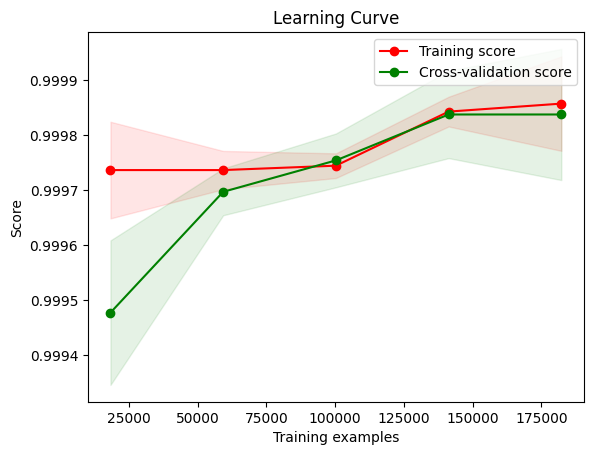

In [62]:
# Cross-validation
scores = cross_val_score(lr_meta_model, meta_train, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    lr_meta_model, meta_train, y_train, cv=5, n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()